In [1]:
%load_ext autoreload
%autoreload 2

import sys
import requests
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from tqdm import tqdm
from sklearn.model_selection import GroupShuffleSplit

translate_Q3_dict = {"highly": 0, "neutral": 1, "minimally": 2}

In [2]:
raw_data_path = "../data/frustration/Protein_Sequence_Distance_Data_v2.parquet"

In [3]:
raw_df = pq.read_table(raw_data_path)

In [4]:
raw_df = raw_df.to_pandas()

In [5]:
raw_df.head()

,funfam_id,proteinID,Res,ChainRes,AA,FrstIndex,FrstClass,FrstClass_traditional
0,3.90.70.10-FF-000138,AF-A0A835R4K6-F1-model_v4_TED02,180,A,N,-0.942,f13,neutral
1,3.90.70.10-FF-000138,AF-A0A835R4K6-F1-model_v4_TED02,181,A,W,0.613,f9,minimally
2,3.90.70.10-FF-000138,AF-A0A835R4K6-F1-model_v4_TED02,182,A,N,-0.838,f12,neutral
3,3.90.70.10-FF-000138,AF-A0A835R4K6-F1-model_v4_TED02,183,A,T,-0.677,f12,neutral
4,3.90.70.10-FF-000138,AF-A0A835R4K6-F1-model_v4_TED02,184,A,A,0.360,f10,neutral


In [6]:
raw_df["proteinID"] = raw_df["proteinID"].astype("category")
grouped = raw_df.groupby("proteinID")

/var/folders/6b/fx6pp2w50tjc2skb5z2mjxph0000gn/T/ipykernel_10417/2499005792.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = raw_df.groupby("proteinID")


### PP the new file

In [ ]:
def fetch_aa_sequence_from_pdb(protein_id):
    """
    Fetches the amino acid sequence from the PDB given a protein ID.
    
    Args:
        protein_id (str): The 4-character PDB ID of the protein.
    
    Returns:
        dict: A dictionary mapping chain IDs to their amino acid sequences.
    """
    url = f"https://data.rcsb.org/rest/v1/core/polymer_entity/{protein_id}/1"
    response = requests.get(url)

    if response.status_code != 200:
        raise ValueError(f"Failed to fetch data for PDB ID {protein_id}. Status code: {response.status_code}")
    
    data = response.json()
    sequence = data.get("entity_poly", {}).get("pdbx_seq_one_letter_code_can", "").replace("\n", "")
    chain_ids = data.get("rcsb_polymer_entity_container_identifiers", {}).get("auth_asym_ids", [])

    return {chain_id: sequence for chain_id in chain_ids}

In [49]:
def fetch_pdb_sequences(pdb_id):
    url = f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{pdb_id}'
    response = requests.get(url)
    if response.status_code != 200:
        print(f"Failed to fetch data for PDB ID {pdb_id}. Status code: {response.status_code}")
        return {}
    data = response.json()[pdb_id.lower()]
    
    res = {}
    for entries in data:
        if 'polypeptide' not in entries['molecule_type'].lower():
            continue
        if 'sequence' in entries:
            sequence = entries['sequence']
        else:
            sequence = ""
        chain_ids = entries['in_chains']
        for chain_id in chain_ids:
            res[chain_id] = sequence
    return res

In [25]:
pdb_id = '1asz'
url = f'https://www.ebi.ac.uk/pdbe/api/pdb/entry/molecules/{pdb_id}'
response = requests.get(url)
if response.status_code != 200:
    raise ValueError(f"Failed to fetch data for PDB ID {pdb_id}. Status code: {response.status_code}")
data = response.json()[pdb_id.lower()]

In [36]:
data[0]['sequence']

'UCCGUGAUAGUUUAAUGGUCAGAAUGGGCGCUUGUCGCGUGCCAGAUCGGGGUUCAAUUCCCCGUCGCGGAGCCA'

In [45]:
res = {}
for entries in data:
    if 'polypeptide' not in entries['molecule_type'].lower():
        continue
    chain_ids = entries['in_chains']
    if 'sequence' in entries:
        sequence = entries['sequence']
    else:
        sequence = ""
    for chain_id in chain_ids:
        res[chain_id] = sequence
print(res)

{'A': 'EDTAKDNYGKLPLIQSRDSDRTGQKRVKFVDLDEAKDSDKEVLFRARVHNTRQQGATLAFLTLRQQASLIQGLVKANKEGTISKNMVKWAGSLNLESIVLVRGIVKKVDEPIKSATVQNLEIHITKIYTISETPEALPILLEDASRSEAEAEAAGLPVVNLDTRLDYRVIDLRTVTNQAIFRIQAGVCELFREYLATKKFTEVHTPKLLGAPSEGGSSVFEVTYFKGKAYLAQSPQFNKQQLIVADFERVYEIGPVFRAENSNTHRHMTEFTGLDMEMAFEEHYHEVLDTLSELFVFIFSELPKRFAHEIELVRKQYPVEEFKLPKDGKMVRLTYKEGIEMLRAAGKEIGDFEDLSTENEKFLGKLVRDKYDTDFYILDKFPLEIRPFYTMPDPANPKYSNSYDFFMRGEEILSGAQRIHDHALLQERMKAHGLSPEDPGLKDYCDGFSYGCPPHAGGGIGLERVVMFYLDLKNIRRASLFPRDPKRLRP', 'B': 'EDTAKDNYGKLPLIQSRDSDRTGQKRVKFVDLDEAKDSDKEVLFRARVHNTRQQGATLAFLTLRQQASLIQGLVKANKEGTISKNMVKWAGSLNLESIVLVRGIVKKVDEPIKSATVQNLEIHITKIYTISETPEALPILLEDASRSEAEAEAAGLPVVNLDTRLDYRVIDLRTVTNQAIFRIQAGVCELFREYLATKKFTEVHTPKLLGAPSEGGSSVFEVTYFKGKAYLAQSPQFNKQQLIVADFERVYEIGPVFRAENSNTHRHMTEFTGLDMEMAFEEHYHEVLDTLSELFVFIFSELPKRFAHEIELVRKQYPVEEFKLPKDGKMVRLTYKEGIEMLRAAGKEIGDFEDLSTENEKFLGKLVRDKYDTDFYILDKFPLEIRPFYTMPDPANPKYSNSYDFFMRGEEILSGAQRIHDHALLQERMKAHGLSPEDPGLKDYCDGFSYGCPPHAGGGIGLERVVMFYLDLKNIRRASLFPRDPKRLRP'}


In [48]:
cntr = 0
for pid, group in tqdm(grouped):
    if not pid.startswith("AF"):
        cntr += 1
print(cntr)

100%|██████████| 986029/986029 [00:24<00:00, 41038.72it/s] 

885


In [50]:
pdb_sequences = {}
for pid, group in tqdm(grouped):
    if not pid.startswith("AF"):
        pdb_id = pid[:4]
        chain_id = pid[4]
        pdb_entry = fetch_pdb_sequences(pdb_id)
        if chain_id not in pdb_entry:
            print(f"{pid}: Chain {chain_id} not found in PDB ID {pdb_id} ({pdb_entry.keys()}).")
            continue
        pdb_sequences[pid] = pdb_entry[chain_id]


  0%|          | 0/986029 [00:00<?, ?it/s]

  0%|          | 421/986029 [01:12<36:38:32,  7.47it/s]

Failed to fetch data for PDB ID 3kau. Status code: 404
3kauB00: Chain B not found in PDB ID 3kau (dict_keys([])).


  0%|          | 621/986029 [01:44<39:54:28,  6.86it/s] 

Failed to fetch data for PDB ID 4juw. Status code: 404
4juwY04: Chain Y not found in PDB ID 4juw (dict_keys([])).


  0%|          | 727/986029 [02:01<40:14:17,  6.80it/s] 

Failed to fetch data for PDB ID 5esy. Status code: 404
5esyB01: Chain B not found in PDB ID 5esy (dict_keys([])).


  0%|          | 842/986029 [02:19<39:34:23,  6.92it/s]

Failed to fetch data for PDB ID 6d5i. Status code: 404
6d5iA02: Chain A not found in PDB ID 6d5i (dict_keys([])).


100%|██████████| 986029/986029 [02:30<00:00, 6547.19it/s]  


In [51]:
pdb_sequences

{'1abrA01': 'EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQERNRYITVELSNSDTESIEVGIDVTNAYVVAYRAGTQSYFLRDAPSSASDYLFTGTDQHSLPFYGTYGDLERWAHQSRQQIPLGLQALTHGISFFRSGGNDNEEKARTLIVIIQMVAEAARFRYISNRVRVSIQTGTAFQPDAAMISLENNWDNLSRGVQESVQDTFPNQVTLTNIRNEPVIVDSLSHPTVAVLALMLFVCNPPN',
 '1apaA01': 'APTLEINTITFDVGNATINKYATFMKSIHNQAKDPTLKCYGIPMLPNTNLTPKYLLVTLQDSSLKTITLMLKRNNLYVMGYADTYNGKCRYHIFKDISNTTERNDVMTTLCPNPSSRVGKNINYDSSYPALEKKVGRPRSQVQLGIQILNSGIGKIYGVDSFTEKTEAEFLLVAIQMVSEAARFKYIENQVKTNFNRAFYPNAKVLNLEESWGKISTAIHNAKNGALTSPLELKNANGSKWIVLRVDDIEPDVGLLKYVNGTCQAT',
 '1apsA00': 'STARPLKSVDYEVFGRVQGVCFRMYAEDEARKIGVVGWVKNTSKGTVTGQVQGPEEKVNSMKSWLSKVGSPSSRIDRTNFSNEKTISKLEYSNFSVRY',
 '1asqB02': 'SQIRHYKWEVEYMFWAPNCNENIVMGINGQFPGPTIRANAGDSVVVELTNKLHTEGVVIHWHGILQRGTPWADGTASISQCAINPGETFFYNFTVDNPGTFFYHGHLGMQRSAGLYGSLIVDPPQGKKEPFHYDGEINLLLSDWWHQSIHKQEVGLSSKPIRWIGEPQTILLNGRGQFDCSIAAKYDSNLEPCKLKGSESCAPYIFHVSPKKTYRIRIASTTALAALNFAIGNHQLLVVEADGNYVQPFYTSDIDIYSGESYSVLITTDQNPSENYWVSVGTRARHPNTPPGLTLLNYLPNSVSKLPTSPPPQTPAWDDFDRSK

In [ ]:
with open("../data/frustration/v2_full_fetch_seqs.fasta", "a") as f:
    for acc, seq in pdb_sequences.items():
        f.write(f">{acc}\n{seq}\n")
# this file is now renamed to v5_full_fetch_seqs.fasta

In [66]:
pid

'AF-Z9JY45-F1-model_v4_TED02'

### Read from file

In [7]:
results = SeqIO.to_dict(SeqIO.parse("../data/frustration/v5_full_fetch_pdb_incl.fasta", "fasta"))
results = {key: str(value.seq) for key, value in results.items()}

In [9]:
results

{'O94446': 'MSNDVDDESKIETKSYEAKDIVYKSKVFAFKDGEYRKAEILMIQKRTRGVVYYVHYNDYNKRLDEWITIDNIDLSKGIEYPPPEKPKKAHGKGKSSKRPKAVDRRRSITAPSKTEPSTPSTEKPEPSTPSGESDHGSNAGNESLPLLEEDHKPESLSKEQEVERLRFSGSMVQNPHEIARIRNINKICIGDHEIEPWYFSPYPKEFSEVDIVYICSFCFCYYGSERQFQRHREKCTLQHPPGNEIYRDDYISFFEIDGRKQRTWCRNICLLSKLFLDHKMLYYDVDPFLFYCMCRRDEYGCHLVGYFSKEKESSENYNLACILTLPQYQRHGYGKLLIQFSYELTKREHKHGSPEKPLSDLGLISYRAYWAEQIINLVLGMRTETTIDELANKTSMTTNDVLHTLQALNMLKYYKGQFIICISDGIEQQYERLKNKKRRRINGDLLADWQPPVFHPSQLRFGW',
 'Q5A7Q2': 'MAVAEIKKEKGSSLSPEPSSPIQILSTEPDANTDIKQEKFTPKDILPGCKVHVSKDGEFRLAEILQEHIKKGRKVFYVHYQDFNKRLDEWIELDRIDFTRSLILPEIKADTKENKSKKKSKSKGQTKLSKNNTTANSTTGTPQPSDGQPIMGDDEMDLENLNVQGLKRPGEEFSREDEIKKLRTSGSMTQNHSEVARVRNLSTIILGEHIIEPWYFSPYPIELTEEDEIYICDFTLSYFGSKKQFERFRSKCSMKHPPGNEIYRDSKVSFWEIDGRKQRTWCRNLCLLSKLFLDHKTLYYDVDPFLFYIMTIKSDQGHHVVGYFSKEKESADGYNVACILTLPCYQKRGFGKLLIQFSYMLTKVERKVGSPEKPLSDLGLLSYRAYWTDTLVKLLVERNSPALFRKNNSQLEYDEAENGKDSSATPTPGPGSNASQSSILASAAASRSGLNSSPIFSNEITIEDISSITCMTTTDILHTLTTLQMLRYYKGQHIIVLTDQIMELYEKLVK

In [10]:
ids = []
full_seqs = []
res_seqs = []
res_idxs = []
frst_idxs = []
frst_classes = []
frst_classes_3 = []
cath_ids = []
cath_T_ids = []

def compare_sequences(seq_a, seq_b, idx):
    if max(idx) >= len(seq_a):
        return False
    for i in range(len(idx)):
        if seq_a[idx[i]] != seq_b[i]:
            return False
    return True

for pid, group in tqdm(grouped):
    if pid.startswith("AF"):
        id = pid.split("-")[1]
    else:
        id = pid
    if id not in results:
        #print(f"{pid} not found in fetched sequences.")
        continue
    full_seq = results.get(id)
    group.sort_values('Res', inplace=True)
    res_seq = group["AA"].values
    res_idx = group["Res"].values - 1
    
    if not compare_sequences(full_seq, res_seq, res_idx):
        #print(f"Sequence mismatch for {pid}")
        continue

    frst_class_3 = group["FrstClass_traditional"].apply(lambda x: translate_Q3_dict[x]).values
    cath_id = group.iloc[0]["funfam_id"].split("-")[0]
    cath_T_id = ".".join(cath_id.split(".")[:-1])

    ids.append(pid)
    full_seqs.append(full_seq)
    res_seqs.append(res_seq)
    res_idxs.append(res_idx)
    frst_idxs.append(group["FrstIndex"].values)
    frst_classes.append(group["FrstClass"].values)
    frst_classes_3.append(frst_class_3)
    cath_ids.append(cath_id)
    cath_T_ids.append(cath_T_id)

python(12197) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 986029/986029 [03:36<00:00, 4562.82it/s]


In [11]:
len(ids), len(full_seqs), len(res_seqs), len(res_idxs), len(frst_idxs), len(frst_classes),  len(frst_classes_3), len(cath_ids), len(cath_T_ids)

(983212, 983212, 983212, 983212, 983212, 983212, 983212, 983212, 983212)

In [12]:
manual_test_cath_T_ids = ["1.10.490", "3.40.710", "3.30.1710", "1.20.58"] # Exclude Rossmann folds 3.40.50 becasue its massive (and you know what else is massive?)

In [77]:
len(cath_T_ids), cath_T_ids[:5]

(983212,
 array(['3.40.420', '3.40.420', '3.30.70', '2.60.40', '2.60.40'],
       dtype='<U9'))

In [14]:
mask = np.where(~np.isin(cath_T_ids, manual_test_cath_T_ids))[0]
mask

array([     0,      1,      2, ..., 983209, 983210, 983211],
      shape=(979602,))

In [76]:
cath_T_ids = np.array(cath_T_ids)
cath_T_ids[mask]

array(['3.40.420', '3.40.420', '3.30.70', ..., '1.10.240', '3.30.70',
       '3.30.70'], shape=(979602,), dtype='<U9')

In [ ]:
test_gss = GroupShuffleSplit(n_splits=1000, test_size=30, random_state=42)
val_ggs = GroupShuffleSplit(n_splits=1000, test_size=30, random_state=42)

In [17]:
for train_idx, test_idx in test_gss.split(X=np.zeros(len(cath_T_ids[mask])), groups=cath_T_ids[mask]):
    if len(test_idx) <= len(ids)*0.03 or len(test_idx) >= len(ids)*0.05:
        print(f"Skipping test size: {len(test_idx)}")
        continue

    print(f"Test size: {len(test_idx)} ({len(test_idx) / len(ids) * 100:.2f}%), Train-val size: {len(train_idx)} ({len(train_idx) / len(ids) * 100:.2f}%)")
    test_ids = np.array(cath_T_ids[mask])[test_idx]
    trainval_ids = np.array(cath_T_ids[mask])[train_idx]
    break

Test size: 44155 (4.49%), Train-val size: 935447 (95.14%)


In [18]:
test_ids

array(['2.160.20', '3.30.930', '3.40.640', ..., '3.10.450', '3.40.640',
       '1.10.420'], shape=(44155,), dtype='<U9')

In [19]:
for train_idx, val_idx in val_ggs.split(X=np.zeros(len(trainval_ids)), groups=trainval_ids):
    if len(val_idx) <= len(ids)*0.03 or len(val_idx) >= len(ids)*0.05:
        print(f"Skipping val size: {len(val_idx)}")
        continue

    print(f"Val size: {len(val_idx)} ({len(val_idx) / len(ids) * 100:.2f}%), Train size: {len(train_idx)} ({len(train_idx) / len(ids) * 100:.2f}%)")
    train_ids = trainval_ids[train_idx]
    val_ids = trainval_ids[val_idx]
    break

Val size: 48610 (4.94%), Train size: 886837 (90.20%)


In [20]:
len(train_ids), len(val_ids), len(test_ids), sum([len(train_ids), len(val_ids), len(test_ids)])

(886837, 48610, 44155, 979602)

In [21]:
train_ids_set = set(train_ids)
val_ids_set = set(val_ids)
test_ids_set = set(test_ids).union(set(manual_test_cath_T_ids)) # Adding manually excluded CATH T ids to test set

In [22]:
# Sanity checks
train_ids_set.intersection(val_ids_set), \
train_ids_set.intersection(test_ids_set), \
val_ids_set.intersection(test_ids_set)

(set(), set(), set())

In [23]:
sets = ["test" if id in test_ids_set else "val" if id in val_ids_set else "train" for id in cath_T_ids]
len(sets), sets[:10]

(983212,
 ['train',
  'train',
  'train',
  'train',
  'train',
  'train',
  'train',
  'train',
  'train',
  'train'])

In [24]:
df_processed = pd.DataFrame({
    "proteinID": ids,
    "full_seq": full_seqs,
    "res_seq": res_seqs,
    "res_idx": res_idxs,
    "frst_idx": frst_idxs,
    "frst_class": frst_classes,
    "frst_class_3": frst_classes_3,
    "set": sets,
    "cath_id": cath_ids,
    "cath_T_id": cath_T_ids
})

In [25]:
df_processed

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,set,cath_id,cath_T_id
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420
1,1apaA01,APTLEINTITFDVGNATINKYATFMKSIHNQAKDPTLKCYGIPMLP...,"[I, N, T, I, T, F, D, V, G, N, A, T, I, N, K, ...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[1.942, -0.924, 0.115, 1.605, 0.26, 1.182, -0....","[f6, f13, f10, f7, f10, f8, f12, f8, f12, f8, ...","[2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, ...",train,3.40.420.10,3.40.420
2,1apsA00,STARPLKSVDYEVFGRVQGVCFRMYAEDEARKIGVVGWVKNTSKGT...,"[S, T, A, R, P, L, K, S, V, D, Y, E, V, F, G, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[-0.325, 0.044, -1.264, 0.794, -0.337, 1.016, ...","[f11, f10, f13, f9, f11, f8, f13, f12, f7, f10...","[1, 1, 0, 2, 1, 2, 1, 1, 2, 1, 2, 1, 2, 2, 1, ...",train,3.30.70.100,3.30.70
3,1asqB02,SQIRHYKWEVEYMFWAPNCNENIVMGINGQFPGPTIRANAGDSVVV...,"[F, H, Y, D, G, E, I, N, L, L, L, S, D, W, W, ...","[130, 131, 132, 133, 134, 135, 136, 137, 138, ...","[1.013, 0.41, 0.682, 0.706, -0.308, -0.895, 1....","[f8, f10, f9, f9, f11, f13, f7, f12, f7, f7, f...","[2, 1, 2, 2, 1, 1, 2, 1, 2, 2, 2, 1, 0, 2, 2, ...",train,2.60.40.420,2.60.40
4,1asqB03,SQIRHYKWEVEYMFWAPNCNENIVMGINGQFPGPTIRANAGDSVVV...,"[P, K, P, P, V, K, F, N, R, R, I, F, L, L, N, ...","[336, 337, 338, 339, 340, 341, 342, 343, 344, ...","[0.308, -0.431, -0.992, 0.04, 1.172, -1.726, 0...","[f10, f11, f13, f10, f8, f14, f9, f12, f10, f1...","[1, 1, 1, 1, 2, 0, 2, 1, 1, 1, 2, 2, 2, 2, 1, ...",train,2.60.40.420,2.60.40
...,...,...,...,...,...,...,...,...,...,...
983207,AF-Z9JUC0-F1-model_v4_TED01,MTWKIVVGGDNAGYGYKEELKALLEADDRVESVTDVGVTGRDDAEL...,"[K, I, V, V, G, G, D, N, A, G, Y, G, Y, K, E, ...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[-0.888, 1.237, 1.324, 1.168, -0.416, -0.209, ...","[f13, f8, f8, f8, f11, f11, f14, f12, f12, f9,...","[1, 2, 2, 2, 1, 1, 0, 1, 1, 1, 2, 1, 2, 0, 0, ...",train,3.40.1400.10,3.40.1400
983208,AF-Z9JVP5-F1-model_v4_TED02,MVDAYTRLVRTAPGRALAARTGLPRPSHLPRRAERPQPVLDPVVVL...,"[A, L, V, T, G, A, A, R, G, I, G, A, A, I, A, ...","[207, 208, 209, 210, 211, 212, 213, 214, 215, ...","[0.489, 1.505, 1.193, -0.466, -0.533, 0.483, -...","[f9, f7, f8, f12, f12, f9, f11, f11, f11, f7, ...","[1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 1, 2, 2, 2, ...",train,3.40.50.720,3.40.50
983209,AF-Z9JWV3-F1-model_v4_TED02,MTSILDELSWRGLVVQSTGLEALGTALADGPVSLYCGFDPTAASLH...,"[S, E, G, G, A, V, W, L, D, A, E, L, T, S, P, ...","[233, 234, 235, 236, 237, 238, 239, 240, 241, ...","[-0.246, -0.039, -0.138, 0.177, 0.058, 1.472, ...","[f11, f11, f11, f10, f10, f7, f11, f8, f15, f1...","[1, 1, 1, 1, 1, 2, 1, 2, 0, 1, 1, 2, 1, 1, 0, ...",train,1.10.240.10,1.10.240
983210,AF-Z9JWZ1-F1-model_v4_TED03,MLRIAVPNKGALSEPASDLLYEAGYRRRGHLKELVLVDEDNGVELF...,"[V, L, I, D, Y, D, I, P, Q, E, K, L, E, A, A, ...","[213, 214, 215, 216, 217, 218, 219, 220, 221, ...","[1.088, 1.267, 1.378, -0.842, 0.61, -1.091, 1....","[f8, f8, f7, f12, f9, f13, f8, f13, f13, f13, ...","[2, 2, 2, 1, 2, 0, 2, 0, 0, 0, 0, 2, 1, 1, 2, ...",train,3.30.70.120,3.30.70


In [26]:
df_processed.to_parquet('../data/frustration/v6_frustration_v2.parquet', compression='gzip')

In [30]:
df_old = pq.read_table("../data/frustration/v4_frustration.parquet.gzip").to_pandas()

In [37]:
df_old_subset = df_old.sample(10000)
df_old_subset.head()

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,set,cath_T_id,frst_class_3
208942,AF-A0A1S4G463-F1-model_v4_TED01,MSSYVVVLLVVLPLVFADVVPVKECKAGSLPSSVDVQGCKKVPCEL...,"[L, P, S, S, V, D, V, Q, G, C, K, K, V, P, C, ...","[29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 4...","[1.151, -1.029, -0.358, 0.514, 1.241, 0.473, 1...","[7, 12, 10, 8, 7, 8, 6, 9, 12, 7, 9, 6, 7, 12,...",train,2.60.40,"[2, 0, 1, 1, 2, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2, ..."
981562,AF-X0VVD2-F1-model_v4_TED01,PGQQVVKVIRDELTALMGEERIGLLLTNRPAVIMLVGLQGCGKTTT...,"[G, L, L, L, T, N, R, P, A, V, I, M, L, V, G, ...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[0.262, 1.258, 0.041, 1.065, 0.119, -0.458, 0....","[9, 7, 9, 7, 9, 11, 8, 12, 10, 7, 6, 8, 7, 7, ...",train,3.40.50,"[1, 2, 1, 2, 1, 1, 2, 0, 1, 2, 2, 2, 2, 2, 1, ..."
946774,AF-R5E845-F1-model_v4_TED03,MNYEKAASEVLALIGGKDNVISAAHCATRLRLVIADNGKCDKNALE...,"[I, Y, V, P, A, K, G, K, V, I, A, L, S, E, V, ...","[474, 475, 476, 477, 478, 479, 480, 481, 482, ...","[1.276, 0.448, 1.277, -0.937, 0.397, -0.193, -...","[7, 8, 7, 12, 9, 10, 10, 10, 7, 6, 10, 7, 11, ...",train,2.70.70,"[2, 1, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2, 1, 1, 2, ..."
780682,AF-A0A7X8DP29-F1-model_v4_TED03,MDMLLKISKELNLHLDFVKNVIELLNEGATIPFIARYRKEATGSMD...,"[A, V, G, V, E, V, N, T, A, S, K, Q, L, L, S, ...","[478, 479, 480, 481, 482, 483, 484, 485, 486, ...","[-0.284, 1.45, -0.816, 1.239, -0.445, 1.312, -...","[10, 6, 11, 7, 11, 7, 12, 10, 8, 11, 12, 12, 6...",train,1.10.150,"[1, 2, 1, 2, 1, 2, 0, 1, 1, 1, 1, 0, 2, 2, 1, ..."
839994,AF-A0A8B2U8U8-F1-model_v4_TED01,MNTEMSKTTCMVSPAEMSQIGEDVGVYKATKKQILSFFSAIPAGAF...,"[P, A, E, M, S, Q, I, G, E, D, V, G, V, Y, K, ...","[13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 2...","[-0.802, -0.407, -1.371, -1.236, -0.585, -0.60...","[11, 10, 13, 12, 11, 11, 7, 10, 13, 14, 7, 10,...",train,1.20.1080,"[1, 1, 0, 0, 1, 1, 2, 1, 0, 0, 2, 1, 2, 1, 0, ..."
...,...,...,...,...,...,...,...,...,...
536506,AF-A0A535HVU2-F1-model_v4_TED01,MAQPTTVTDATFKDEVLDASVPVLVDFWAAWCAPCKMIAPIVEELA...,"[T, V, T, D, A, T, F, K, D, E, V, L, D, A, S, ...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[0.016, 1.361, -0.011, -0.346, -0.894, 0.828, ...","[9, 6, 10, 10, 12, 8, 8, 7, 12, 11, 7, 9, 8, 8...",train,3.40.30,"[1, 2, 1, 1, 1, 2, 2, 2, 1, 1, 2, 1, 2, 2, 1, ..."
449834,AF-A0A402EK71-F1-model_v4_TED01,MSEVSKDSVQKILLQLECHFTWMLLKQDITPEELEERIEDQIEFLP...,"[D, S, V, Q, K, I, L, L, Q, L, E, C, H, F, T, ...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[0.735, -0.074, 1.313, -0.902, -0.784, 1.885, ...","[8, 10, 7, 12, 11, 5, 6, 7, 10, 6, 8, 6, 10, 7...",test,1.25.40,"[2, 1, 2, 1, 1, 2, 2, 2, 1, 2, 2, 2, 1, 2, 1, ..."
667141,AF-A0A6P7MEX7-F1-model_v4_TED01,MARRVAVIGGGSSGLACIKCCLDEGLEPVCFESSDDIGGLWRFKEN...,"[V, A, V, I, G, G, G, S, S, G, L, A, C, I, K, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[1.253, 0.475, 1.186, 1.319, -0.163, -0.207, 0...","[7, 8, 7, 7, 10, 10, 9, 11, 10, 10, 8, 10, 6, ...",train,3.50.50,"[2, 1, 2, 2, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 1, ..."
547822,AF-A0A5A8C6A2-F1-model_v4_TED03,MPDFYKVLGVSRSAGDDEIKKAYRKLAIKWHPDKNQHRRAESEAKF...,"[T, R, E, G, N, D, L, V, V, K, A, R, V, T, L, ...","[249, 250, 251, 252, 253, 254, 255, 256, 257, ...","[0.166, -0.191, -1.67, -0.427, -0.87, -1.646, ...","[9, 10, 13, 10, 11, 13, 7, 8, 7, 11, 8, 10, 6,...",train,2.60.260,"[1, 1, 0, 1, 1, 0, 2, 2, 2, 1, 2, 1, 2, 1, 2, ..."


In [38]:
df_subset = df_processed.loc[df_processed["proteinID"].isin(df_old_subset["proteinID"])]
df_subset.head()

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,set,cath_id,cath_T_id
386,AF-A0A009MPL2-F1-model_v4_TED01,MLKQTLLYTGKAKSVYETDNADHLILVFRDDASAFNGEKIEQLDRK...,"[Q, T, L, L, Y, T, G, K, A, K, S, V, Y, E, T, ...","[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[-0.78, 0.656, 1.37, 1.346, 0.68, -0.527, -0.2...","[f12, f9, f7, f7, f9, f12, f11, f7, f11, f14, ...","[1, 2, 2, 2, 2, 1, 1, 2, 1, 0, 1, 2, 2, 0, 1, ...",train,3.30.200.20,3.30.200
487,AF-A0A010RTU5-F1-model_v4_TED03,MVKILSLTLACLASRLAIGATVNYDFTVGWVTANPDGAFDRPVIGI...,"[T, V, E, L, N, V, I, M, D, N, L, G, D, G, A, ...","[335, 336, 337, 338, 339, 340, 341, 342, 343, ...","[-0.011, 1.292, -0.833, 1.207, -0.796, 1.225, ...","[f11, f8, f12, f8, f12, f8, f9, f8, f14, f10, ...","[1, 2, 1, 2, 1, 2, 2, 2, 0, 1, 2, 2, 0, 1, 1, ...",train,2.60.40.420,2.60.40
665,AF-A0A011SIQ1-F1-model_v4_TED01,MFSITERDLAATIDHAILKPELTRADVDAELDIAAEWRVFSVCVRP...,"[R, D, L, A, A, T, I, D, H, A, I, L, K, P, E, ...","[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 1...","[-0.169, -1.232, 1.606, 0.703, -0.273, -0.461,...","[f11, f13, f7, f9, f11, f12, f8, f13, f11, f9,...","[1, 0, 2, 2, 1, 1, 2, 0, 1, 2, 2, 2, 1, 1, 2, ...",train,3.20.20.70,3.20.20
673,AF-A0A011UKS3-F1-model_v4_TED02,MTTHVFHRALKSALPCVAGGDGITLRDAEGRTYIDACGGAAVSCLG...,"[V, L, E, A, M, A, A, Q, A, R, Q, A, A, Y, I, ...","[51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 6...","[1.306, 1.369, -1.243, 0.533, 0.591, 0.735, 0....","[f8, f7, f13, f9, f9, f9, f10, f13, f9, f12, f...","[2, 2, 0, 1, 2, 2, 1, 0, 2, 1, 1, 1, 1, 0, 2, ...",test,3.40.640.10,3.40.640
719,AF-A0A014MD88-F1-model_v4_TED01,MLSQKSAETVRATLPAVGEAIGTITELFYRKLFTAHPELLRNMFNR...,"[K, S, A, E, T, V, R, A, T, L, P, A, V, G, E, ...","[4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,...","[2.644, -0.542, 0.49, -0.342, 0.234, 1.208, -0...","[f5, f12, f9, f11, f10, f8, f11, f11, f11, f8,...","[2, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 2, 1, 0, ...",test,1.10.490.10,1.10.490
...,...,...,...,...,...,...,...,...,...,...
982740,AF-X6LYP7-F1-model_v4_TED01,MVIGLACLSGFFVYEKIVRIKQYTFFKNWNSICKNLFTMTIFENNI...,"[A, V, A, K, L, S, S, Y, R, S, K, D, P, N, T, ...","[88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 9...","[0.985, 1.352, 0.314, -1.474, 1.175, -0.666, -...","[f8, f7, f10, f14, f8, f12, f12, f14, f11, f10...","[2, 2, 1, 0, 2, 1, 1, 0, 1, 1, 1, 1, 2, 2, 1, ...",train,3.40.140.10,3.40.140
982974,AF-X8B410-F1-model_v4_TED01,MPRLIEQFEHGLDAPICLTWELTYACNLACVHCLSSSGKRDPRELS...,"[I, C, L, T, W, E, L, T, Y, A, C, N, L, A, C, ...","[15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 2...","[1.466, 1.181, 1.333, -1.218, 1.327, -1.301, 1...","[f7, f8, f7, f13, f8, f13, f8, f11, f9, f8, f3...","[2, 2, 2, 0, 2, 0, 2, 1, 2, 2, 2, 0, 2, 1, 2, ...",train,3.20.20.70,3.20.20
983048,AF-X8IVJ6-F1-model_v4_TED01,MSAESAPATAKTPSVPSSQLFSLAGQTAVVTGGTRGIGAACAIALA...,"[L, A, G, Q, T, A, V, V, T, G, G, T, R, G, I, ...","[22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 3...","[0.989, -1.266, -0.809, -0.977, -0.168, 0.622,...","[f8, f13, f12, f13, f11, f9, f8, f8, f12, f11,...","[2, 0, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 2, 1, 2, ...",train,3.40.50.720,3.40.50
983150,AF-X8JTV6-F1-model_v4_TED02,MWSDSRCIAAGDVVILWMTREDIQPIVVTPGKELNGRYGVYRHSDL...,"[T, L, A, L, P, H, R, T, Q, I, L, Y, H, A, D, ...","[74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 8...","[-0.368, 0.669, -1.258, -0.882, 0.682, 1.255, ...","[f11, f9, f13, f13, f9, f8, f12, f10, f9, f6, ...","[1, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, ...",train,3.40.50.150,3.40.50


In [39]:
frst_scores = np.concatenate(df_subset['frst_idx'].values)
frst_scores_old = np.concatenate(df_old_subset['frst_idx'].values)
frst_scores.shape, frst_scores_old.shape

((1897685,), (1897685,))

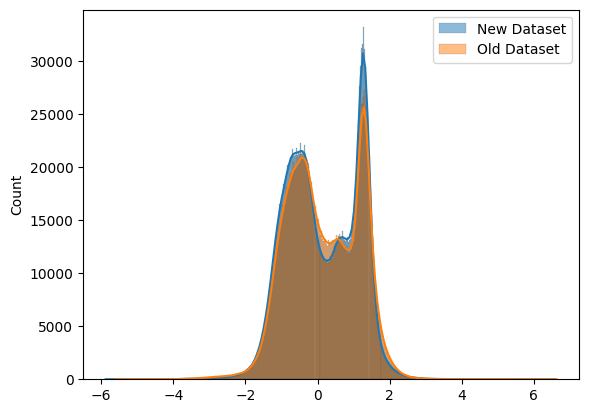

In [40]:
sns.histplot(frst_scores, kde=True, label='New Dataset')
sns.histplot(frst_scores_old, kde=True, label='Old Dataset')
plt.legend()

In [67]:
df_old["set"].value_counts()

set
train    896034
test      56892
val       29926
Name: count, dtype: int64

In [63]:
df_processed["set_old"] = "not_in_old"
df_processed.loc[df_processed["proteinID"].isin(df_old.loc[df_old["set"] == "train"]["proteinID"]), "set_old"] = "train"
df_processed.loc[df_processed["proteinID"].isin(df_old.loc[df_old["set"] == "val"]["proteinID"]), "set_old"] = "val"
df_processed.loc[df_processed["proteinID"].isin(df_old.loc[df_old["set"] == "test"]["proteinID"]), "set_old"] = "test"
df_processed["set_old"].value_counts()

set_old
train         896034
test           56892
val            29926
not_in_old       360
Name: count, dtype: int64

In [64]:
df_processed["set"].value_counts()

set
train    886837
val       48610
test      47765
Name: count, dtype: int64

In [66]:
df_processed.loc[df_processed["set"] == "train", "cath_T_id"].nunique(), \
df_processed.loc[df_processed["set"] == "val", "cath_T_id"].nunique(), \
df_processed.loc[df_processed["set"] == "test", "cath_T_id"].nunique()

(499, 30, 33)

In [62]:
df_processed.to_parquet('../data/frustration/v7_frustration_v2.parquet.gzip', compression='gzip')

In [111]:
df_processed.head(2)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,set,cath_id,cath_T_id,set_old
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420,not_in_old
1,1apaA01,APTLEINTITFDVGNATINKYATFMKSIHNQAKDPTLKCYGIPMLP...,"[I, N, T, I, T, F, D, V, G, N, A, T, I, N, K, ...","[5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17...","[1.942, -0.924, 0.115, 1.605, 0.26, 1.182, -0....","[f6, f13, f10, f7, f10, f8, f12, f8, f12, f8, ...","[2, 1, 1, 2, 1, 2, 1, 2, 1, 2, 2, 1, 2, 1, 0, ...",train,3.40.420.10,3.40.420,not_in_old


In [69]:
dfpgr = df_processed.groupby("cath_T_id")

In [71]:
dfpgr =dfpgr.sample(10)

In [74]:
dfpgr.loc[dfpgr["set"] == "train"].shape, dfpgr.loc[dfpgr["set"] == "val"].shape, dfpgr.loc[dfpgr["set"] == "test"].shape

((4990, 11), (300, 11), (330, 11))

In [75]:
dfpgr.loc[dfpgr["set_old"] == "train"].shape, dfpgr.loc[dfpgr["set_old"] == "val"].shape, dfpgr.loc[dfpgr["set_old"] == "test"].shape

((4814, 11), (300, 11), (500, 11))

### Add new splits

In [97]:
df = pq.read_table("../data/frustration/v7_frustration_v2.parquet.gzip").to_pandas()

In [98]:
df.head(1)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,set,cath_id,cath_T_id,set_old
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420,None


In [99]:
cath_T_ids = df["cath_T_id"].values
len(cath_T_ids)

983212

In [100]:
test_gss = GroupShuffleSplit(n_splits=100, test_size=30, random_state=42)
val_ggs = GroupShuffleSplit(n_splits=100, test_size=30, random_state=42)

In [101]:
n_splits = 3 # one manual split with the manual topologies in test set below. total 5 splits
current_split = 0
for train_idx, test_idx in test_gss.split(X=np.zeros(len(cath_T_ids)), groups=cath_T_ids):
    if len(test_idx) <= len(ids)*0.03 or len(test_idx) >= len(ids)*0.05:
        print(f"Skipping test size: {len(test_idx)}")
        continue

    #print(f"Test size: {len(test_idx)} ({len(test_idx) / len(ids) * 100:.2f}%), Train-val size: {len(train_idx)} ({len(train_idx) / len(ids) * 100:.2f}%)")
    test_ids = np.array(cath_T_ids)[test_idx]
    trainval_ids = np.array(cath_T_ids)[train_idx]

    for train_idx, val_idx in val_ggs.split(X=np.zeros(len(trainval_ids)), groups=trainval_ids):
        if len(val_idx) <= len(ids)*0.03 or len(val_idx) >= len(ids)*0.05:
            print(f"Skipping val size: {len(val_idx)}")
            continue

        #print(f"Val size: {len(val_idx)} ({len(val_idx) / len(ids) * 100:.2f}%), Train size: {len(train_idx)} ({len(train_idx) / len(ids) * 100:.2f}%)")
        print(f"Split {current_split}: Test size: {len(test_idx)} ({len(test_idx) / len(ids) * 100:.2f}%), Val size: {len(val_idx)} ({len(val_idx) / len(ids) * 100:.2f}%), Train size: {len(train_idx)} ({len(train_idx) / len(ids) * 100:.2f}%)")
        train_ids = trainval_ids[train_idx]
        val_ids = trainval_ids[val_idx]
        break

    train_ids_set = set(train_ids)
    val_ids_set = set(val_ids)
    test_ids_set = set(test_ids)
    df[f"split_{current_split}"] = ["test" if id in test_ids_set else "val" if id in val_ids_set else "train" for id in cath_T_ids]

    if current_split == n_splits:
        break
    current_split += 1

Skipping val size: 50333
Skipping val size: 25611
Split 0: Test size: 31429 (3.20%), Val size: 32010 (3.26%), Train size: 919773 (93.55%)
Skipping val size: 21074
Skipping val size: 285991
Skipping val size: 250192
Split 1: Test size: 32439 (3.30%), Val size: 33284 (3.39%), Train size: 917489 (93.32%)
Skipping test size: 24682
Skipping val size: 22909
Skipping val size: 257538
Skipping val size: 259058
Skipping val size: 19601
Skipping val size: 87091
Skipping val size: 53299
Skipping val size: 74532
Skipping val size: 23066
Skipping val size: 81326
Skipping val size: 27718
Split 2: Test size: 38165 (3.88%), Val size: 38081 (3.87%), Train size: 906966 (92.25%)
Skipping test size: 74504
Skipping val size: 51288
Skipping val size: 26641
Skipping val size: 24622
Skipping val size: 54215
Split 3: Test size: 32282 (3.28%), Val size: 45700 (4.65%), Train size: 905230 (92.07%)


In [102]:
df.head(1)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,set,cath_id,cath_T_id,set_old,split_0,split_1,split_2,split_3
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420,None,train,train,val,train


In [109]:
df.rename(columns={"set_old": "split_old", "set": "split_test"}, inplace=True)

In [110]:
df.head(1)

,proteinID,full_seq,res_seq,res_idx,frst_idx,frst_class,frst_class_3,split_test,cath_id,cath_T_id,split_old,split_0,split_1,split_2,split_3
0,1abrA01,EDRPIKFSTEGATSQSYKQFIEALRERLRGGLIHDIPVLPDPTTLQ...,"[E, D, R, P, I, K, F, S, T, E, G, A, T, S, Q, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[1.25, -0.466, 0.868, -2.941, 1.638, -0.771, 1...","[f8, f12, f9, f17, f7, f12, f7, f12, f11, f12,...","[2, 1, 2, 0, 2, 1, 2, 1, 1, 1, 1, 2, 2, 0, 0, ...",train,3.40.420.10,3.40.420,None,train,train,val,train


In [112]:
df.to_parquet('../data/frustration/v8_frustration_v2.parquet.gzip', compression='gzip')